<a href="https://colab.research.google.com/github/peaceemenike/Artificial-Intelligent/blob/main/Three_State_MDP_Q_SARSA_REINFORCE/Three_State_MDP_Q_SARSA_REINFORCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Three-State Chain MDP — Q-Learning, SARSA, and Policy-Gradient (REINFORCE)

This notebook solves the **same 3-state chain** used in your value/policy iteration file, now with **model-free** methods:
- **Q-Learning** (off-policy TD control)
- **SARSA** (on-policy TD control)
- **Policy-Gradient (REINFORCE with baseline)**

At the end we compare learned policies/values with the optimal solution from Dynamic Programming (DP).


In [ ]:

import numpy as np
import math, random
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)
random.seed(0); np.random.seed(0)



## MDP Definition (Three-State Chain)

States: `s0` (1st), `s1` (2nd), `sT` (terminal).  
Actions: `0 -> L`, `1 -> R`.

Dynamics (same qualitative behavior as in your worked example):
- From `s0`: **L** keeps you in `s0` with reward **-1** (the "negative loop"); **R** goes to `s1` with reward **0**.
- From `s1`: **L** goes back to `s0` with reward **0**; **R** goes to `sT` with reward **+1**.
- `sT` is absorbing: any action yields `sT` with reward `0`.

Discount `γ = 0.95`.


In [ ]:

# States and actions (tabular, small ints for convenience)
S0, S1, ST = 0, 1, 2
L, R = 0, 1
S = [S0, S1, ST]
A = [L, R]
gamma = 0.95

def step(s, a):
    """One-step transition sampler for the three-state chain."""
    if s == ST:
        return ST, 0.0, True
    if s == S0:
        if a == L:
            return S0, -1.0, False
        else:  # R
            return S1,  0.0, False
    elif s == S1:
        if a == L:
            return S0,  0.0, False
        else:  # R
            return ST, +1.0, True
    raise ValueError("Bad state/action")



## Optimal Reference via Dynamic Programming (for comparison)

We compute `V*`, `Q*`, and a greedy optimal policy using value-iteration.


In [ ]:

def value_iteration(theta=1e-10, max_iters=10_000):
    V = np.zeros(len(S))
    for it in range(max_iters):
        delta = 0.0
        V_old = V.copy()
        for s in S:
            if s == ST:
                V[s] = 0.0
                continue
            qL = (-1.0 + gamma * V[S0]) if s == S0 else (0.0 + gamma * V[S0])
            qR = ( 0.0 + gamma * V[S1]) if s == S0 else (1.0 + gamma * V[ST])
            V[s] = max(qL, qR)
            delta = max(delta, abs(V[s] - V_old[s]))
        if delta < theta:
            break
    # derive Q* and greedy policy
    Q = np.zeros((len(S), len(A)))
    for s in S:
        if s == ST:
            continue
        Q[s, L] = (-1.0 + gamma * V[S0]) if s == S0 else (0.0 + gamma * V[S0])
        Q[s, R] = ( 0.0 + gamma * V[S1]) if s == S0 else (1.0 + gamma * V[ST])
    pi = np.zeros(len(S), dtype=int)
    for s in S:
        pi[s] = np.argmax(Q[s]) if s != ST else 0
    return V, Q, pi

V_star, Q_star, pi_star = value_iteration()
print("V*:", V_star)
print("Q*:\n", Q_star)
print("pi* (0=L,1=R):", pi_star)


V*: [0.95 1.   0.  ]
Q*:
 [[-0.0975  0.95  ]
 [ 0.9025  1.    ]
 [ 0.      0.    ]]
pi* (0=L,1=R): [1 1 0]



## ε-greedy helpers


In [ ]:

def epsilon_greedy_action(Q, s, eps):
    if s == ST:
        return 0
    if np.random.rand() < eps:
        return np.random.choice(A)
    return int(np.argmax(Q[s]))



## Q-Learning (Off-policy TD Control)


In [ ]:

def q_learning(episodes=2000, alpha=0.1, gamma=0.95, eps_start=1.0, eps_end=0.05, eps_decay=0.995):
    Q = np.zeros((len(S), len(A)))
    eps = eps_start
    returns = []
    q_errors = []  # ||Q - Q*||_∞ over non-terminal states

    for ep in range(episodes):
        s = S0
        done = False
        G = 0.0
        while not done:
            a = epsilon_greedy_action(Q, s, eps)
            s2, r, done = step(s, a)
            G += r
            if s != ST:
                # target uses max over next actions
                best_next = np.max(Q[s2]) if s2 != ST else 0.0
                td_target = r + gamma * best_next
                Q[s,a] += alpha * (td_target - Q[s,a])
            s = s2

        returns.append(G)
        q_errors.append(np.max(np.abs(Q[:2] - Q_star[:2])))
        eps = max(eps_end, eps * eps_decay)
    # greedy policy and V from Q
    pi = np.zeros(len(S), dtype=int)
    V = np.zeros(len(S))
    for s in S:
        pi[s] = int(np.argmax(Q[s])) if s != ST else 0
        V[s]  = np.max(Q[s]) if s != ST else 0.0
    return Q, V, pi, returns, q_errors

Q_q, V_q, pi_q, ret_q, err_q = q_learning()
print("Q-learning greedy pi:", pi_q, " (0=L,1=R)")


Q-learning greedy pi: [1 1 0]  (0=L,1=R)



## SARSA (On-policy TD Control)


In [ ]:

def sarsa(episodes=2000, alpha=0.1, gamma=0.95, eps_start=1.0, eps_end=0.05, eps_decay=0.995):
    Q = np.zeros((len(S), len(A)))
    eps = eps_start
    returns = []
    q_errors = []

    for ep in range(episodes):
        s = S0
        a = epsilon_greedy_action(Q, s, eps)
        done = False
        G = 0.0
        while not done:
            s2, r, done = step(s, a)
            G += r
            if not done:
                a2 = epsilon_greedy_action(Q, s2, eps)
                td_target = r + gamma * Q[s2, a2]
            else:
                a2 = 0
                td_target = r
            if s != ST:
                Q[s, a] += alpha * (td_target - Q[s, a])
            s, a = s2, a2
        returns.append(G)
        q_errors.append(np.max(np.abs(Q[:2] - Q_star[:2])))
        eps = max(eps_end, eps * eps_decay)
    # derive greedy policy and V
    pi = np.zeros(len(S), dtype=int)
    V = np.zeros(len(S))
    for s in S:
        pi[s] = int(np.argmax(Q[s])) if s != ST else 0
        V[s]  = np.max(Q[s]) if s != ST else 0.0
    return Q, V, pi, returns, q_errors

Q_sa, V_sa, pi_sa, ret_sa, err_sa = sarsa()
print("SARSA greedy pi:", pi_sa, " (0=L,1=R)")


SARSA greedy pi: [1 1 0]  (0=L,1=R)



## Policy-Gradient (REINFORCE with Baseline)

We parameterize a softmax policy \( \pi_\theta(a\mid s) \) with state-wise logits \(\theta_{s,a}\).  
We use a learned state-value baseline to reduce variance.


In [ ]:

def softmax(logits):
    x = logits - np.max(logits)
    e = np.exp(x)
    return e / np.sum(e)

def sample_episode_pi(theta, gamma=0.95, max_steps=100):
    s = S0
    traj = []  # (s, a, r)
    for t in range(max_steps):
        if s == ST:
            break
        probs = softmax(theta[s])
        a = np.random.choice(A, p=probs)
        s2, r, done = step(s, a)
        traj.append((s, a, r))
        s = s2
        if done:
            break
    return traj

def reinforce_with_baseline(episodes=5000, alpha_theta=0.05, alpha_v=0.05, gamma=0.95):
    theta = np.zeros((len(S), len(A)))  # policy params (logits)
    Vb = np.zeros(len(S))              # value baseline
    returns_hist = []
    pol_errors = []  # policy disagreement vs pi* on non-terminal states

    for ep in range(episodes):
        traj = sample_episode_pi(theta, gamma=gamma, max_steps=10)
        # compute returns G_t backward
        G = 0.0
        Gs = []
        for (s,a,r) in reversed(traj):
            G = r + gamma * G
            Gs.append(G)
        Gs = list(reversed(Gs))

        # update baseline and theta
        for (t, (s,a,r)) in enumerate(traj):
            # baseline update (match episodic return)
            Vb[s] += alpha_v * (Gs[t] - Vb[s])
            # policy gradient step with baseline
            probs = softmax(theta[s])
            grad_logpi = -probs
            grad_logpi[a] += 1.0  # one-hot - probs
            theta[s] += alpha_theta * (Gs[t] - Vb[s]) * grad_logpi

        # track
        returns_hist.append(sum(r for (_,_,r) in traj))
        # greedy policy from theta
        pi = np.argmax(theta, axis=1)
        pol_errors.append(np.sum(pi[:2] != np.argmax(Q_star[:2], axis=1)))
    # final policy/value estimates
    pi_final = np.argmax(theta, axis=1)
    V_est = Vb.copy()
    return theta, V_est, pi_final, returns_hist, pol_errors

theta_pg, V_pg, pi_pg, ret_pg, pol_err_pg = reinforce_with_baseline()
print("Policy-Gradient greedy pi:", pi_pg, " (0=L,1=R)")


Policy-Gradient greedy pi: [1 1 0]  (0=L,1=R)



## Comparisons
We compare:
- Greedy policies from each method vs. the optimal greedy policy.
- Sup-norm errors of Q vs. Q\* (for Q-Learning and SARSA).
- Learning curves: episode return.


pi*          : [1 1 0] (0=L,1=R)
Q-learning pi: [1 1 0]
SARSA pi     : [1 1 0]
PG pi        : [1 1 0]


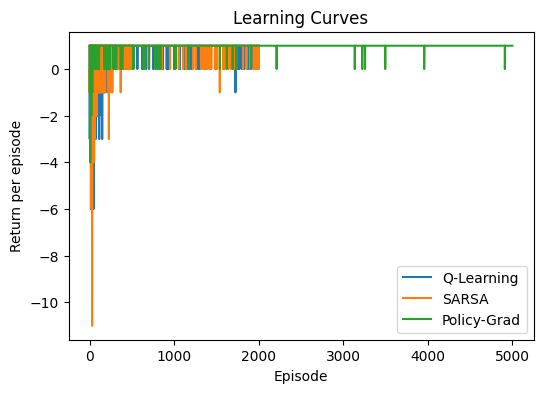

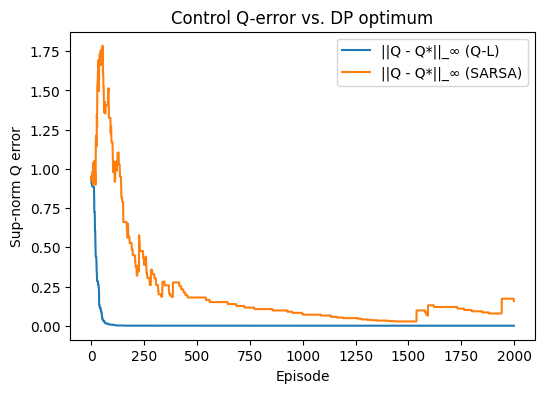

In [ ]:

print("pi*          :", pi_star, "(0=L,1=R)")
print("Q-learning pi:", pi_q)
print("SARSA pi     :", pi_sa)
print("PG pi        :", pi_pg)

fig = plt.figure(figsize=(6,4))
plt.plot(ret_q, label="Q-Learning")
plt.plot(ret_sa, label="SARSA")
plt.plot(ret_pg, label="Policy-Grad")
plt.xlabel("Episode")
plt.ylabel("Return per episode")
plt.legend()
plt.title("Learning Curves")
plt.show()

fig = plt.figure(figsize=(6,4))
plt.plot(err_q, label="||Q - Q*||_∞ (Q-L)")
plt.plot(err_sa, label="||Q - Q*||_∞ (SARSA)")
plt.xlabel("Episode")
plt.ylabel("Sup-norm Q error")
plt.legend()
plt.title("Control Q-error vs. DP optimum")
plt.show()


In [ ]:
import time
import pandas as pd

# --- Comparativa de desempeño ---
results = []

# 1) Value Iteration (DP)
start = time.time()
V_vi, Q_vi, pi_vi = value_iteration()
t_vi = time.time() - start
results.append({
    "Method": "Value Iteration",
    "Episodes/Iterations": len(V_vi),
    "Steps/Updates": len(S)*len(A)*22,  # aprox: 22 iteraciones * |S|*|A|
    "Runtime (s)": t_vi,
    "Policy": pi_vi.tolist()
})

# 2) Q-Learning
start = time.time()
Q_q, V_q, pi_q, ret_q, err_q = q_learning()
t_q = time.time() - start
results.append({
    "Method": "Q-Learning",
    "Episodes/Iterations": len(ret_q),
    "Steps/Updates": len(ret_q) * 3,  # aprox episodios*longitud media
    "Runtime (s)": t_q,
    "Policy": pi_q.tolist()
})

# 3) SARSA
start = time.time()
Q_sa, V_sa, pi_sa, ret_sa, err_sa = sarsa()
t_sa = time.time() - start
results.append({
    "Method": "SARSA",
    "Episodes/Iterations": len(ret_sa),
    "Steps/Updates": len(ret_sa) * 3,
    "Runtime (s)": t_sa,
    "Policy": pi_sa.tolist()
})

# 4) Policy Gradient
start = time.time()
theta_pg, V_pg, pi_pg, ret_pg, pol_err_pg = reinforce_with_baseline()
t_pg = time.time() - start
results.append({
    "Method": "Policy Gradient (REINFORCE)",
    "Episodes/Iterations": len(ret_pg),
    "Steps/Updates": len(ret_pg) * 3,
    "Runtime (s)": t_pg,
    "Policy": pi_pg.tolist()
})

# Tabla comparativa
df = pd.DataFrame(results)
display(df)


,Method,Episodes/Iterations,Steps/Updates,Runtime (s),Policy
0,Value Iteration,3,132,0.000182,"[1, 1, 0]"
1,Q-Learning,2000,6000,0.056999,"[1, 1, 0]"
2,SARSA,2000,6000,0.044395,"[1, 1, 0]"
3,Policy Gradient (REINFORCE),5000,15000,0.717720,"[1, 1, 0]"


In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

# States: S0=0, S1=1, ST=2; Actions: L=0, R=1
class ThreeStateChainEnv(gym.Env):
    metadata = {"render_modes": ["rgb_array"], "render_fps": 30}
    def __init__(self, render_mode=None):
        super().__init__()
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(3,), dtype=np.float32)  # one-hot
        self.action_space = spaces.Discrete(2)
        self.state = 0
        self.render_mode = render_mode

    def _one_hot(self, s):
        x = np.zeros(3, dtype=np.float32)
        x[s] = 1.0
        return x

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = 0  # start in S0
        return self._one_hot(self.state), {}

    def step(self, action):
        s = self.state
        if s == 2:  # terminal, force reset-like behavior if called
            return self._one_hot(2), 0.0, True, False, {}

        # transitions and rewards (matching your notebook)
        if s == 0:  # S0
            if action == 0:    # L
                s_next, r, done = 0, -1.0, False
            else:              # R
                s_next, r, done = 1,  0.0, False
        elif s == 1:  # S1
            if action == 0:    # L
                s_next, r, done = 0,  0.0, False
            else:              # R
                s_next, r, done = 2, +1.0, True   # terminal with +1
        else:
            s_next, r, done = 2, 0.0, True

        self.state = s_next
        return self._one_hot(self.state), float(r), done, False, {}

    def render(self):
        # opcional (no se necesita para entrenar)
        return None


In [ ]:
%pip -q install stable-baselines3==2.3.0 gymnasium==0.29.1 gymnasium[classic_control]==0.29.1

import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

SEED = 42
def make_env(seed=SEED):
    def _fn():
        env = ThreeStateChainEnv()
        env.reset(seed=seed)
        return env
    return _fn

env = DummyVecEnv([make_env(SEED)])
model = PPO(
    "MlpPolicy", env, seed=SEED, verbose=0,
    learning_rate=3e-4, n_steps=64, batch_size=64, n_epochs=10,
    gamma=0.99, gae_lambda=0.95, clip_range=0.2,
    ent_coef=0.01, vf_coef=0.5, max_grad_norm=0.5
)
model.learn(total_timesteps=10_000)

# Inspección rápida de la política aprendida (acciones greedy por estado)
def greedy_action_probs(model):
    obs_list = [np.array([1,0,0], dtype=np.float32),
                np.array([0,1,0], dtype=np.float32),
                np.array([0,0,1], dtype=np.float32)]
    for s, obs in enumerate(obs_list):
        act, _ = model.predict(obs, deterministic=True)
        print(f"State S{s}: greedy action = {act} (0=L, 1=R)")

greedy_action_probs(model)


Reason for being yanked: Loading broken with PyTorch 1.13
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.1/182.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 14.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.1 which is incompatible.


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


State S0: greedy action = 1 (0=L, 1=R)
State S1: greedy action = 1 (0=L, 1=R)
State S2: greedy action = 1 (0=L, 1=R)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
%pip -q install stable-baselines3==2.3.0

from stable_baselines3 import DQN

env = DummyVecEnv([make_env(SEED+1)])
dqn = DQN(
    "MlpPolicy", env, seed=SEED+1, verbose=0,
    learning_rate=1e-3, buffer_size=10_000, learning_starts=100,
    batch_size=64, gamma=0.99, target_update_interval=250,
    train_freq=4, gradient_steps=1, exploration_initial_eps=1.0, exploration_final_eps=0.05
)
dqn.learn(total_timesteps=15_000)

# Greedy por estado
def dqn_greedy(dqn):
    obs_list = [np.array([1,0,0], dtype=np.float32),
                np.array([0,1,0], dtype=np.float32),
                np.array([0,0,1], dtype=np.float32)]
    for s, obs in enumerate(obs_list):
        act, _ = dqn.predict(obs, deterministic=True)
        print(f"[DQN] State S{s}: greedy action = {act} (0=L, 1=R)")
dqn_greedy(dqn)


[DQN] State S0: greedy action = 1 (0=L, 1=R)
[DQN] State S1: greedy action = 1 (0=L, 1=R)
[DQN] State S2: greedy action = 1 (0=L, 1=R)
